<a href="https://colab.research.google.com/github/Angelvj/TFG/blob/main/code/jupyter/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import tensorflow as tf
import keras as k
import nibabel as nib
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import time
import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = '/content/drive/My Drive/Machine learning/data'

else: 
  DATA_PATH = '../../data'

def load_image(filename):    
    """
    
    Parameters
    ----------
    filename : str
        relative path to de image

    Returns
    -------
    img : numpy ndarray
        array containing the image
        
    """
    img = nib.load(filename)
    img = np.asarray(img.dataobj)
    img = np.expand_dims(img, axis=3)
    return img


def load_images_from_dir(dirname):
    """
    
    Parameters
    ----------
    dirname : str
        name of the directory containing images.

    Returns
    -------
    imgs : numpy ndarray
        array containing all of the images in the folder.

    """
    imgs = []

    for filename in tqdm(glob.glob(dirname + '/*.nii')):
        imgs.append(load_image(filename))
        
    imgs = np.stack(imgs)
    return imgs

def load_data(dirs_dict, categorical = False):
    """
    
    Parameters
    ----------
    dirs_dict : dictionary
        dictionary containing data folders name, and the label for the images
        on each forlder.

    Returns
    -------
    x : numpy ndarray
        array containing the images.
    y : numpy ndarray
        array containig the label of each image.

    """
    first = True
    for key, value in dirs_dict.items():
        if first:
            X = load_images_from_dir(value)
            y = np.full((X.shape[0]), key, dtype=np.uint8)
            first = False
        else:
            X_current = load_images_from_dir(value)
            X = np.concatenate((X, X_current))
            y = np.concatenate((y, np.full((X_current.shape[0]), key, dtype=np.uint8)))
            
    if categorical:
        y = k.utils.to_categorical(y)
    
    return X, y

def impute_nan_values(imgs, inplace=True):
    # Replace nan values with 0
    return np.nan_to_num(imgs, copy= not inplace)

# Load PET images with labels
print('\n --- Loading PET data --- \n')
time.sleep(0.5)
X, y = load_data({0: DATA_PATH + "/ppNOR/PET", 
                  1: DATA_PATH + "/ppAD/PET",
                  2: DATA_PATH + "/ppMCI/PET"})

# Separate into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)


impute_nan_values(X_train)
impute_nan_values(X_test)

print('\n --- PET data loaded --- \n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 --- Loading PET data --- 



100%|██████████| 111/111 [00:00<00:00, 307.39it/s]



 --- PET data loaded --- 



In [18]:
def learning_curve(hist):
    history_dict = hist.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()

In [20]:
def cross_validate(model, x_train, y_train, num_folds, opt, batch_size, epochs, verbose=0, show_history=False):

    # Creamos un objeto kfold, especificando el número de segmentos que queremos utilizar,
    # además utilizamos shuffle true, para que los num_folds conjuntos disjuntos se seleccionen
    # de forma aleatoria, evitando de esta forma problemas que podría haber si los datos
    # estuvieran ordenados siguiendo una cierta distribución

    skfold = StratifiedKFold(n_splits = num_folds, shuffle=True)

    model.compile(loss = k.losses.categorical_crossentropy, optimizer=opt,
                metrics = ['accuracy'])

    initial_weights = model.get_weights()

    acc_per_fold = []
    loss_per_fold = []

    fold_no = 1

    for train, test in skfold.split(x_train, y_train):

        # En cada fold, comenzamos con los pesos iniciales. Tratamos de que las 5
        # folds sean lo más independientes posible.
        model.set_weights(initial_weights)

        print('------------------------------------------------------------------------')
        print(f'Entrenando para el fold {fold_no} ...')


        print('Clases en train: ', np.sum(k.utils.to_categorical(y_train[train]), axis=0))
        print('Clases en validación: ', np.sum(k.utils.to_categorical(y_train[test]), axis=0))

        history = model.fit(x_train[train], 
                            k.utils.to_categorical(y_train[train]), 
                            batch_size= batch_size,
                            epochs=epochs, verbose = verbose, 
                            validation_data = (x_train[test], k.utils.to_categorical(y_train[test]))
                            )

        if show_history:
            # Mostramos la evolución en cada fold
            learning_curve(history)

        # Número de épocas que se han utilizado
        print('Numero de épocas realizadas: ', len(history.history['loss']))

        # Calculamos la bondad del modelo para el fold reservado para testing
        scores = model.evaluate(x_train[test], k.utils.to_categorical(y_train[test]), verbose=0)

        # Vamos guardando el accuracy y pérdida para cada fold
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        print(f'Resultado para el fold {fold_no}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

        fold_no += 1

    # ==  Mostramos los valores medios == 
    print('------------------------------------------------------------------------')
    print('Resultados por cada fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Media de los resultados para todos los folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)}')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 77, 93, 66, 32)    896       
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 38, 46, 33, 32)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 36, 44, 31, 32)    27680     
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 18, 22, 15, 32)    0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 190080)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 190080)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)             

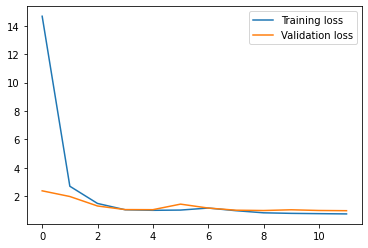

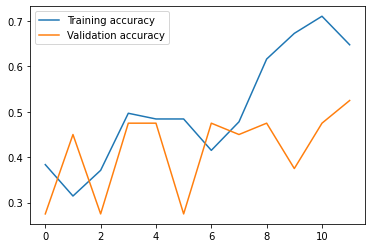

Numero de épocas realizadas:  12
Resultado para el fold 1: loss de 0.9717931747436523; accuracy de 52.49999761581421%
------------------------------------------------------------------------
Entrenando para el fold 2 ...
Clases en train:  [43. 45. 71.]
Clases en validación:  [11. 11. 18.]
Epoch 1/12
10/10 [==============================] - 2s 156ms/step - loss: 5.5804 - accuracy: 0.3396 - val_loss: 4.7033 - val_accuracy: 0.4500
Epoch 2/12
10/10 [==============================] - 1s 145ms/step - loss: 2.4027 - accuracy: 0.3711 - val_loss: 1.2845 - val_accuracy: 0.4500
Epoch 3/12
10/10 [==============================] - 1s 146ms/step - loss: 1.1325 - accuracy: 0.4340 - val_loss: 1.0412 - val_accuracy: 0.4500
Epoch 4/12
10/10 [==============================] - 1s 146ms/step - loss: 1.1434 - accuracy: 0.3711 - val_loss: 1.1579 - val_accuracy: 0.4500
Epoch 5/12
10/10 [==============================] - 1s 145ms/step - loss: 1.0743 - accuracy: 0.4403 - val_loss: 1.4117 - val_accuracy: 0.4500


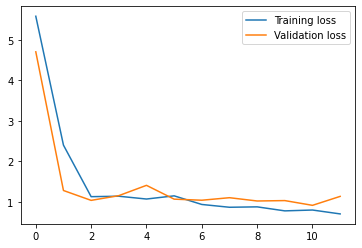

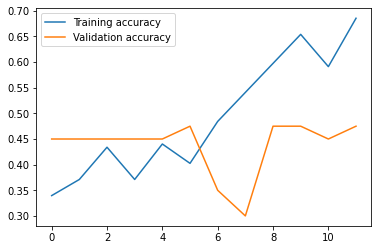

Numero de épocas realizadas:  12
Resultado para el fold 2: loss de 1.1394835710525513; accuracy de 47.49999940395355%
------------------------------------------------------------------------
Entrenando para el fold 3 ...
Clases en train:  [43. 45. 71.]
Clases en validación:  [11. 11. 18.]
Epoch 1/12
10/10 [==============================] - 2s 157ms/step - loss: 6.5853 - accuracy: 0.3585 - val_loss: 1.3019 - val_accuracy: 0.4500
Epoch 2/12
10/10 [==============================] - 1s 146ms/step - loss: 1.2219 - accuracy: 0.3899 - val_loss: 1.2582 - val_accuracy: 0.2750
Epoch 3/12
10/10 [==============================] - 1s 146ms/step - loss: 1.1440 - accuracy: 0.4151 - val_loss: 1.1639 - val_accuracy: 0.4500
Epoch 4/12
10/10 [==============================] - 1s 146ms/step - loss: 1.0708 - accuracy: 0.4277 - val_loss: 1.0407 - val_accuracy: 0.4500
Epoch 5/12
10/10 [==============================] - 1s 146ms/step - loss: 1.0233 - accuracy: 0.5283 - val_loss: 1.0508 - val_accuracy: 0.4500


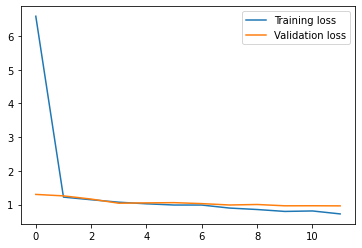

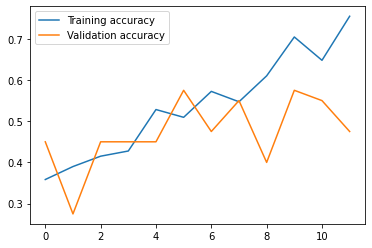

Numero de épocas realizadas:  12
Resultado para el fold 3: loss de 0.9621248245239258; accuracy de 47.49999940395355%
------------------------------------------------------------------------
Entrenando para el fold 4 ...
Clases en train:  [44. 44. 71.]
Clases en validación:  [10. 12. 18.]
Epoch 1/12
10/10 [==============================] - 2s 156ms/step - loss: 6.1750 - accuracy: 0.3208 - val_loss: 4.2336 - val_accuracy: 0.2500
Epoch 2/12
10/10 [==============================] - 1s 145ms/step - loss: 1.6702 - accuracy: 0.3396 - val_loss: 1.1740 - val_accuracy: 0.2750
Epoch 3/12
10/10 [==============================] - 1s 145ms/step - loss: 1.0904 - accuracy: 0.4528 - val_loss: 1.0926 - val_accuracy: 0.4500
Epoch 4/12
10/10 [==============================] - 1s 147ms/step - loss: 1.0720 - accuracy: 0.4214 - val_loss: 1.1104 - val_accuracy: 0.3000
Epoch 5/12
10/10 [==============================] - 1s 146ms/step - loss: 1.0695 - accuracy: 0.4151 - val_loss: 1.0691 - val_accuracy: 0.3750


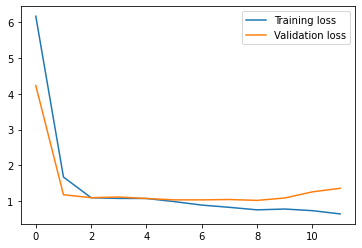

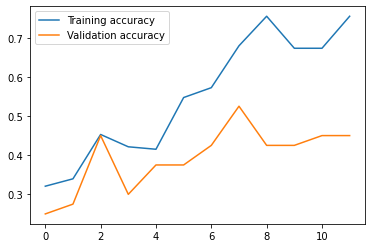

Numero de épocas realizadas:  12
Resultado para el fold 4: loss de 1.3549848794937134; accuracy de 44.999998807907104%
------------------------------------------------------------------------
Entrenando para el fold 5 ...
Clases en train:  [43. 45. 72.]
Clases en validación:  [11. 11. 17.]
Epoch 1/12
10/10 [==============================] - 2s 156ms/step - loss: 5.9242 - accuracy: 0.3375 - val_loss: 3.3542 - val_accuracy: 0.2821
Epoch 2/12
10/10 [==============================] - 1s 146ms/step - loss: 1.8086 - accuracy: 0.3000 - val_loss: 1.1284 - val_accuracy: 0.4615
Epoch 3/12
10/10 [==============================] - 1s 146ms/step - loss: 1.1576 - accuracy: 0.3812 - val_loss: 1.1658 - val_accuracy: 0.4359
Epoch 4/12
10/10 [==============================] - 1s 147ms/step - loss: 1.0996 - accuracy: 0.4000 - val_loss: 1.1382 - val_accuracy: 0.2821
Epoch 5/12
10/10 [==============================] - 1s 145ms/step - loss: 1.1115 - accuracy: 0.3562 - val_loss: 1.0817 - val_accuracy: 0.4359

In [ ]:
# basic 3D cnn model

# Model configuration
sample_shape = (79,95,68,1)

# First very basic model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()


# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# # Fit model to data
# history = model.fit(X_train, y_train, batch_size=batch_size, 
#                     epochs=no_epochs, verbose=verbosity, validation_split=validation_split)

# Generate generalization metrics
# score = model.evaluate(X_test, y_test, verbose=0)
# print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# # Plot history: Categorical crossentropy & Accuracy
# # plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
# # plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
# plt.plot(history.history['accuracy'], label='Accuracy (training data)')
# plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
# # plt.title('Model performance for 3D MNIST Keras Conv3D example')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.show()


cross_validate(model, X_train, y_train, 5, k.optimizers.Adam(lr=0.0001), 16, 12, 
               verbose = 1, show_history = True)